# To predict diabetes using PIMA diabetes data

In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
## Loading dataset
data = pd.read_csv("kaggle_diabetes.txt")

In [3]:
print('The Shape of the dataset is {}'.format(data.shape))

The Shape of the dataset is (2000, 9)


In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


### Checking Null values

In [5]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

There are no null values

Text(0, 0.5, 'Count')

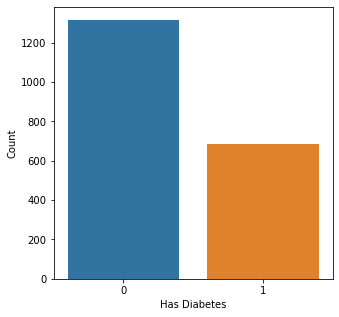

In [6]:
# Plotting the Outcomes based on the number of dataset entries
plt.figure(figsize=(5,5))
sns.countplot(x='Outcome', data=data)

# Headings
plt.xlabel('Has Diabetes')
plt.ylabel('Count')

We can see, that dataset is Balanced dataset

In [7]:
## Number of postive and negative outcomes
diabetes_pos_count=len(data.loc[data['Outcome']==True])
diabetes_neg_count=len(data.loc[data['Outcome']==False])
diabetes_neg_count,diabetes_pos_count

(1316, 684)

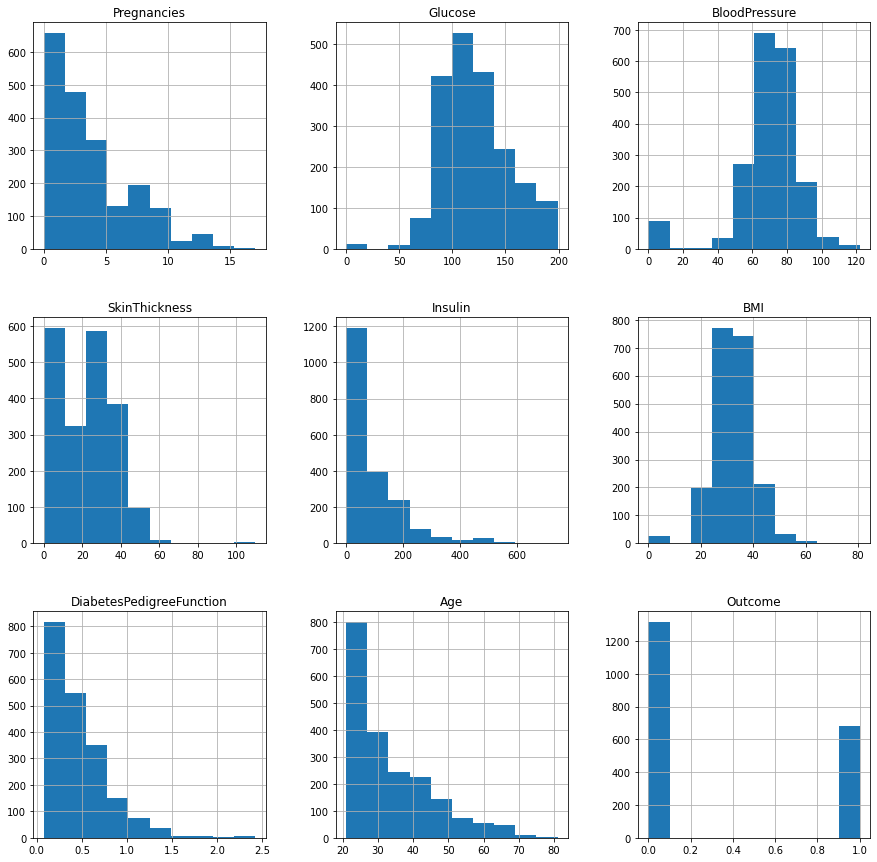

In [8]:
## Visualizing distribution of the features
plot_dist= data.hist(figsize = (15,15))

We can see  the distribution of Pregnancies, Age and Diabetes Pedigree Function have log normal distribution other feature have wavy distribution. So, there are many 0 values.

In [9]:
# Replacing the 0 values from ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] by NaN
df= data.copy(deep=True)
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.isnull().sum()

Pregnancies                   0
Glucose                      13
BloodPressure                90
SkinThickness               573
Insulin                     956
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

We can see that many 0  values are replaced by NAN

In [10]:
df['Glucose'].fillna(df['Glucose'].mean(),inplace=True)
df['BloodPressure'].fillna(df['BloodPressure'].mean(),inplace=True)
df['SkinThickness'].fillna(df['SkinThickness'].median(),inplace=True)
df['Insulin'].fillna(df['Insulin'].median(),inplace=True)
df['BMI'].fillna(df['BMI'].median(),inplace=True)

In [11]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

All the nan values have been replaced

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

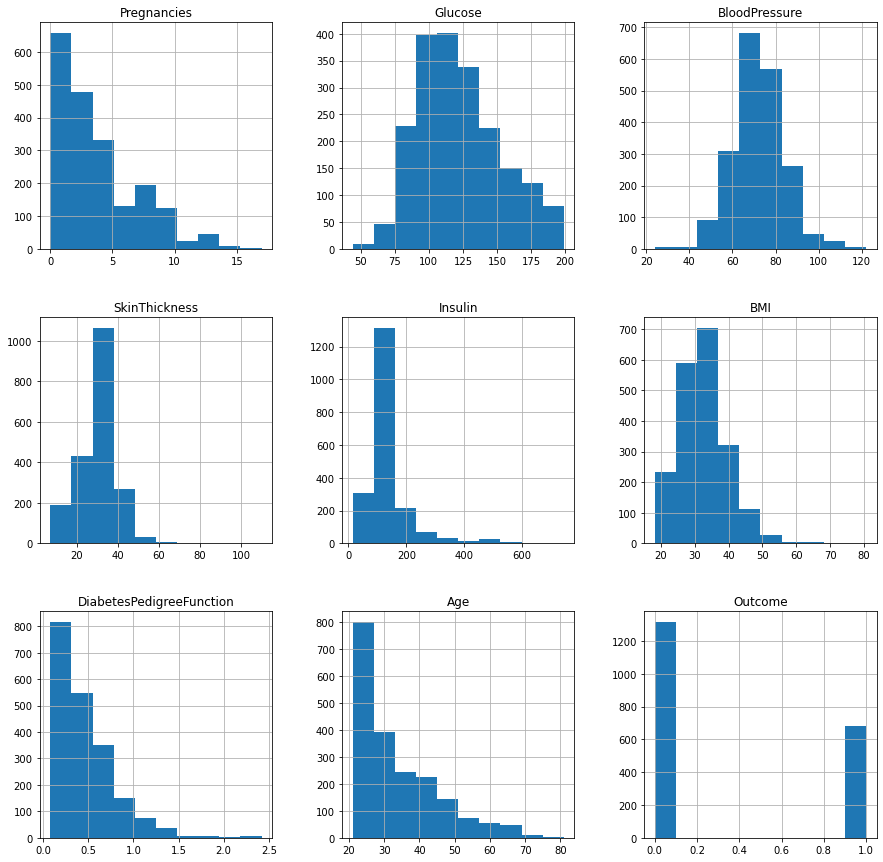

In [12]:
df.hist(figsize = (15,15))

## Feature Selection

<AxesSubplot:>

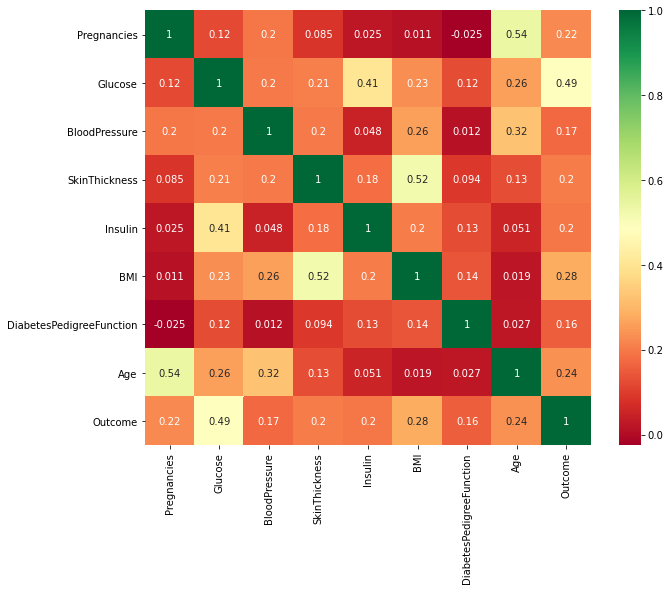

In [13]:
plt.figure(figsize=(10,8))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap="RdYlGn")

In [14]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [15]:
X=df.drop(['Outcome'],axis=1)
y=df['Outcome']

In [16]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

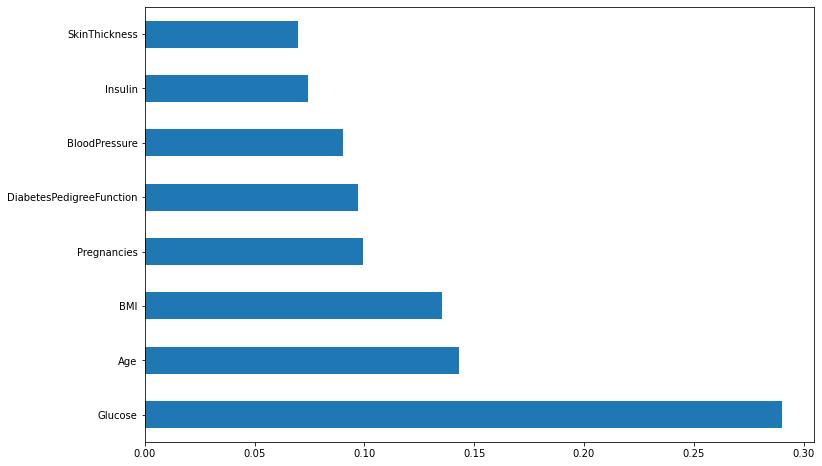

In [17]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

We can see the most important feature is Glucose

In [18]:
## Feature Scaling
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
X_scaled=min_max.fit_transform(X)

In [19]:
## Train Test split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_scaled, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (1600, 8), X_test size: (400, 8)


## Model Building

In [27]:
# Using GridSearchCV to find the best algorithm for this problem
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

In [44]:
# Creating a function to calculate best model for this problem
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {
                'C': [1,5,10]
               }
        },
        
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5,10]
            }
        },
        
        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10,15,20,50,100,200]
            }
        },
        
        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [1,10,20],
                'kernel': ['rbf','linear']
            }
        }

    }
    
    scores = [] 
    cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
        
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })
        
    return pd.DataFrame(scores, columns=['model','best_parameters','score'])

In [45]:
find_best_model(X_train,y_train)

,model,best_parameters,score
0,logistic_regression,{'C': 1},0.760625
1,decision_tree,"{'criterion': 'gini', 'max_depth': 10}",0.895625
2,random_forest,{'n_estimators': 200},0.949375
3,svm,"{'C': 20, 'kernel': 'rbf'}",0.770000


Note: Since the Random Forest algorithm has the highest accuracy we can build the model using it

In [23]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(RandomForestClassifier(n_estimators=20, random_state=0), X_train, y_train, cv=5)
print('Average Accuracy : {}%'.format(round(sum(score)*100/len(score)), 3))

Average Accuracy : 95%


In [24]:
# Creating Random Forest Model
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=0)

In [25]:
## Using k fold cross validation in order to know the score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

print(cross_val_score( classifier,X,y,cv=cv2))

[0.99   0.9675 0.9725 0.98   0.985 ]


We can see Random forest's accuracy through K_fold cross validation

## Model Evaluation

In [26]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
y_pred=classifier.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
cm

array([[269,   3],
       [  1, 127]], dtype=int64)

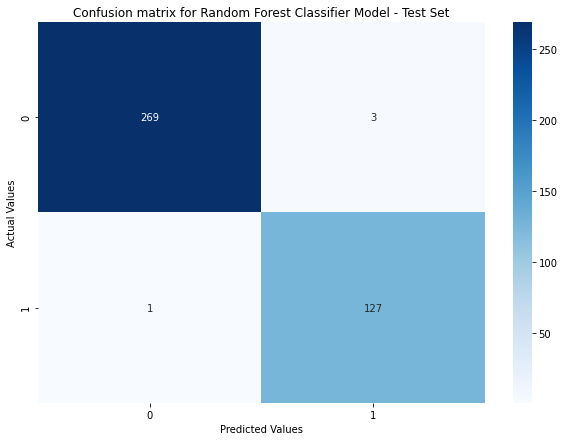

In [27]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


In [28]:
## Accuracy Score
score=accuracy_score(y_test,y_pred)
print('The accuracy is {}%'.format(round(score,3)*100))

The accuracy is 99.0%


In [29]:
## Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       272
           1       0.98      0.99      0.98       128

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [30]:
# Creating a confusion matrix for training set
y_train_pred = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[1043,    1],
       [   1,  555]], dtype=int64)

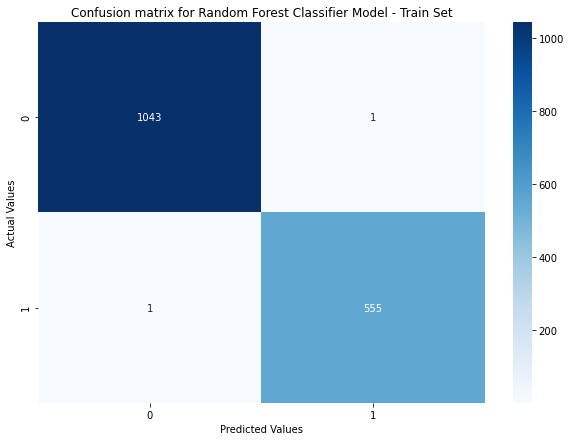

In [31]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for Random Forest Classifier Model - Train Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [32]:
# Accuracy Score
score = round(accuracy_score(y_train, y_train_pred),4)*100
print("Accuracy on trainning set: {}%".format(score))

Accuracy on trainning set: 99.88%


In [33]:
# Classification Report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      1.00      1.00       556

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



### Prediction




In [40]:
# Creating a function for prediction
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age):
    preg = int(Pregnancies)
    glucose = float(Glucose)
    bp = float(BloodPressure)
    st = float(SkinThickness)
    insulin = float(Insulin)
    bmi = float(BMI)
    dpf = float(DPF)
    age = int(Age)

    x = [[preg, glucose, bp, st, insulin, bmi, dpf, age]]
   

    return classifier.predict(x)

In [41]:
# Prediction 1
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(2, 138, 62, 35, 0, 33.6, 0.127, 47)
if prediction:
    print('Oops! You have diabetes.')
else:
    print("Great! You don't have diabetes.")

Oops! You have diabetes.


### KNN ALgorithm

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
knn_model=KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [27]:
knn_model.score(X_train,y_train)

0.9

In [28]:
knn_model.score(X_test,y_test)

0.815

In [29]:
y_pred=knn_model.predict(X_test)

In [30]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn_model_model.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Train set Accuracy:  0.9
Test set Accuracy:  0.815


In [31]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.995 , 0.9325, 0.8975, 0.8575, 0.815 , 0.8325, 0.84  , 0.8175,
       0.8   ])

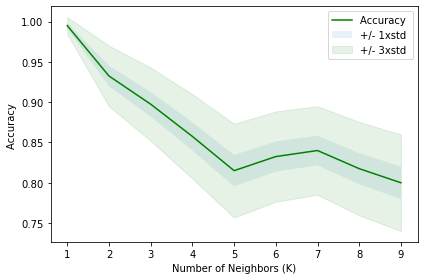

In [32]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### Decison Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
d_t_model=DecisionTreeClassifier(criterion='entropy')

In [36]:
d_t_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [38]:
d_t_model.score(X_test,y_test)

0.98

In [39]:
y_pred=d_t_model.predict(X_test)

In [41]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred))

DecisionTrees's Accuracy:  0.98


In [ ]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "drugtree.png"
featureNames = my_data.columns[0:5]
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### Logistic Regresion

In [22]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(C=0.01,solver='lbfgs')
lr.fit(X_train,y_train)

LogisticRegression(C=0.01)

In [23]:
lr.score(X_test,y_test)

0.68

In [33]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],"solver":['lbfgs','sag', 'saga','newton-cg']}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_sel

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_sel

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_sel

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_sel

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selecti

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_sel

C:\Users\Hamzah\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [     nan      nan 0.6525        nan 0.6525   0.6525   0.6525   0.6525
      nan      nan 0.6525        nan 0.6525   0.6525   0.6525   0.6525
      nan      nan 0.761875      nan 0.755625 0.756875 0.755625 0.755625
      nan      nan 0.7675        nan 0.771875 0.771875 0.771875 0.771875
      nan      nan 0.771875      nan 0.770625 0.770625 0.770625 0.770625
      nan      nan 0.771875      nan 0.771875 0.771875 0.771875 0.771875
      nan      nan 0.771875      nan 0.771875 0.771875 0.771875 0.771875]
  warnings.warn(


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']})

In [34]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.771875


## SVM

In [35]:
from sklearn import svm

In [41]:
para={'C':[1,0.1,0.01,10,100],'kernel':['rbf','linear']}
cl=svm.SVC(kernel='rbf',C=0.001)
grid=GridSearchCV(cl,para)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(C=0.001),
             param_grid={'C': [1, 0.1, 0.01, 10, 100],
                         'kernel': ['rbf', 'linear']})

In [42]:
grid.score(X_test,y_test)

0.8775

In [44]:
grid.best_params_

{'C': 100, 'kernel': 'rbf'}